## Installation of Packages and other settings

In [17]:
!--NotebookApp.iopub_data_rate_limit=1e11 -qq
!pip install pandas-profiling && pip install mlxtend && pip install missingpy && !pip install tpot -qq

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option
/bin/bash: !pip: command not found


In [0]:
!pip install tpot -qq
!pip install --upgrade tensorflow -qq

## Import libraries

In [0]:
import warnings
warnings.filterwarnings('ignore') 

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.max_seq_items = 2000

import pprint
pp = pprint.PrettyPrinter(indent=4)

from timeit import default_timer
import numpy as np
import seaborn as sns
import pandas_profiling
import tempfile
import os

from google.colab import drive

# Keras Modules
from tensorflow import keras
from tensorflow.keras.metrics import (MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, 
                          BatchNormalization, Dropout)
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.regularizers import l1
from tensorflow import data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Plotting modules
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from sklearn.decomposition import PCA

In [0]:
# categorical_df.loc[categorical_df.v8.isnull(), "v8"].index[:10]
# numeric_df[numeric_df.writhome.isnull()].index[:10]
# missing_writhome = list(numeric_df[numeric_df.writhome.isnull()].index[:10])
# imputed_df.loc[missing_writhome, "writhome"].head()
# print(f"writhome attribute has: {imputed_df.writhome.isnull().sum()} missing values")
# print(imputed_df.writhome.agg(['median', 'var', 'std', 'kurt', 'skew']))
# print(imputed_df.writhome.describe())
# print(impute_df[df.writhome.isnull()].head())
# missing_cnt_h = list(categorical_df[categorical_df.cnt_h.isnull()].index)
# imputed_df.loc[missing_cnt_h, "cnt_h"].head()
# print(f"cnt_h attribute has: {imputed_df.cnt_h.isnull().sum()} missing values")
# print(imputed_df.cnt_h.agg(['median', 'var', 'std', 'kurt', 'skew']))
# print(imputed_df.cnt_h.describe())
# print(impute_df[df.writhome.isnull()].head())

## Mappings and Constants

In [0]:
DRIVENAME = '/content/drive/'
FILENAME = "/content/drive/My Drive/sharpestminds_dataset/hw5-trainingset-cl3770.csv"
IMPUTED_FILENAME = "/content/drive/My Drive/sharpestminds_dataset/imputed_df.csv"

CONSIDERED_MISSING_VALUES = ['999', 9995, '9995', 9996, '9996', 9997, "9997", 9998, '9998', 9999, '9999', '99999']
REDUNDANT_FEATURES = ["readytolearn_wle_ca", "icthome_wle_ca", "ictwork_wle_ca", 
                      "influence_wle_ca", "planning_wle_ca", "readhome_wle_ca", 
                      "readwork_wle_ca", "taskdisc_wle_ca", "writhome_wle_ca", 
                      "writwork_wle_ca", "ageg10lfs", "ageg10lfs_t", "edcat7", 
                      "edcat8", "isco2c", "isic2c", "isic2l","earnflag", "reg_tl2", "lng_bq", 
                      "lng_ci", "edlevel3", "nfehrsnjr", "nfehrsjr", "nfe12jr", 
                      "fnfe12jr", "fnfaet12jr", "faet12jr", "faet12njr", "fe12", "monthlyincpr",
                      "earnhrdcl", "earnhrbonusdcl", "row", "uni", "cntryid_e", "v270", 
                      "v205", "neet", "v84", "nfe12njr", "fnfaet12njr"
                     ]

ORDINAL_VARIABLE_MAPPING = [
    [["v233", "v280", "v103", "v15", "v24", "v108", "v218", "v171", "v189", 
     "v204", "v166", "v267", "v292", "v155", "v165", "v190", "v288", 
     "v276","v43", "v197", "v214", "v7", "v175", "v139", "v123", "v14", "v178",
    "v34", "v106", "v246", "v131", "v111", "v173", "v260", "v164", "v186", "v240", "v208",
    "v275", "v132", "v141", "v25", "v177", "v149", "v23", "v193", "v237", "v162", "v146",
    "v277", "v40", "v73", "v195"], 
    ['Never', 'Less than once a month','Less than once a week but at least once a month','At least once a week but not every day','Every day']],
    [['v244', "v65", "v263", "v158", "v57", "v170", "v198", "v191", "v114", "v27"], ['Not at all', 'Very little', 'To some extent', 'To a high extent','To a very high extent']], 
    [["v151"], ['Aged 15 or younger', 'Aged 16-19', 'Aged 20-24', 'Aged 25-29','Aged 30-34', 'Aged 35 or older']],
    [["v181"], ['Extremely dissatisfied', 'Dissatisfied', 'Neither satisfied nor dissatisfied', 'Satisfied', 'Extremely satisfied']],
    [["v271"], ['Straightforward','Moderate','Complex']], 
    [["v247", "v134", "v13", "v18", "v26", "v124", "v99", "v282", "v51", "v2", "v229", "v248"], ['Never','Rarely or never', 'Rarely','Less than once a week', 
                                                                                         'Less than once a week but at least once a month' ,'At least once a week']],
    [["v85", "v50", "v69"], ['Strongly disagree', 'Disagree', 'Neither agree nor disagree', 'Agree', 'Strongly agree']],
    [["v291", "v77"], ['None of the time', 'Up to a quarter of the time','Up to half of the time','More than half of the time','All of the time']],
    [["v269"], ['Not useful at all', 'Somewhat useful' , 'Moderately useful','Very useful']],
    [["v216"], ['Rarely or never','Less than once a week', 'At least once a week']],
    [["v253", "v278", "v284"], ['Never', 'Rarely', 'Less than once a month', 'Less than once a week but at least once a month', 
                        'At least once a week', 'At least once a week but not every day', 'Every day']],
    [["ageg5lfs"], ['Aged 16-19','Aged 20-24','Aged 25-29','Aged 30-34','Aged 35-39', 'Aged 40-44', 'Aged 45-49','Aged 50-54','Aged 55-59','Aged 60-65']],
    [["v289"], ['No income', 'Lowest quintile','Next lowest quintile','Mid-level quintile', 'Next to highest quintile' ,'Highest quintile']],
    [["v261"], ['0 - 20 hours','21 - 40 hours', '41 - 60 hours' , '61 - 80 hours', '81 - 100 hours', 'More than 100 hours']],
    [["v221"], ['None','Less than 1 month','1 to 6 months','7 to 11 months', '1 or 2 years','3 years or more']],
    [["v82", "v70"], ['Self-employed or unpaid family worker', 'Employee, not supervisor', 'Self-employed, not supervisor',
                      'Employee, supervising fewer than 5 people', 'Employee, supervising more than 5 people', 'Self-employed, supervisor']],
    [["v200"], ['Not definable', 'Less than high school', 'High school', 'Above high school']],
    [["v62"], ['A higher level would be needed', 'This level is necessary', 'A lower level would be sufficient']],
    [["v236"], ['No, not at all', 'There were no such costs', 'No employer or prospective employer at that time' ,'Yes, partly', 'Yes, totally']],
    [["v19"], ['Aged 19 or younger', 'Aged 20-24', 'Aged 25-29', 'Aged 30-34' ,'Aged 35-39' ,'Aged 40-44', 'Aged 45-49', 'Aged 50-54', 'Aged 55 or older']],
    [["imyrcat"], ['In host country 5 or fewer years', 'In host country more than 5 years', 'Non-immigrants']],
    [["v48"], ['1 to 10 people', '11 to 50 people', '51 to 250 people', 'More than 1000 people', '251 to 1000 people']],
    [["v47"], ['Days', 'Weeks',  'Hours']],
    [["iscoskil4"], ['Elementary occupations', 'Skilled occupations','Semi-skilled blue-collar occupations', 'Semi-skilled white-collar occupations']],
    [["v94"], ['Respondent reported no learning activities', 'Respondent reported 1 learning activity', 
               'Respondent reported learning activities but number is not known', 'Respondent reported more than 1 learning activity']],
    [["v8"], ['Decreased', 'Stayed more or less the same', 'Increased']],
    [['edcat6'], ['Lower secondary or less (ISCED 1,2, 3C short or less)\xa0',
                'Upper secondary (ISCED 3A-B, C long)',
                'Post-secondary, non-tertiary (ISCED 4A-B-C)',
                'Tertiary – bachelor degree (ISCED 5A)',
                'Tertiary - bachelor/master/research degree (ISCED 5A/6)',
                'Tertiary – master/research degree (ISCED 5A/6)',
                'Tertiary – professional degree (ISCED 5B)']]
]

BINARY_VARIABLE_MAPPING = {
    "gender_r": {'Male': 0, 'Female': 1},
    "faet12": {'Did not participate in formal AET': 0, 'Participated in formal AET': 1},
    "v46" : {'One job or business': 0, 'More than one job or business': 1},
    "v53" : {'Employee': 0, 'Self-employed': 1},
    "nfe12" : {'Did not participate in NFE': 0, 'Participated in NFE': 1},
    "nativelang" : {'Did not participate in NFE': 0, 'Participated in NFE': 1},
    "nopaidworkever": {"Has not has paid work ever": 0, "Has had paid work": 1},
    "paidwork5" : {"Has not had paid work in past 5 years": 0, "Has had paid work in past 5 years": 1},
    "paidwork12" : {"Has not had paid work during the 12 months preceding the survey": 0, "Has had paid work during the 12 months preceding the survey": 1},
    "aetpop" : {"Excluded from AET population": 0, "AET population": 1},
    # "edwork" : {"In work only": 0, "In education and work": 1},
    # "v122" : {'Yes, unpaid work for family business': 0, 'Yes, paid work one job or business': 1, 'Yes, paid work more than one job or business or number of jobs/businesses missing': 2},
    "nativelang": {'Test language not same as native language': 0, 'Test language same as native language':1},
    "fnfaet12": {'Did not participate in formal or non-formal AET': 0, 'Participated in formal and/or non-formal AET': 1}
}

METRICS = [ MeanSquaredError(name='mse'),
      MeanAbsoluteError(name='mae'),
      RootMeanSquaredError(name="rmse")
      ]

EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## Functions

In [0]:
def split_positive_negative(dataframe, target="target"):
    positive_cases = dataframe.loc[dataframe[target]==1, :]
    negative_cases = dataframe.loc[dataframe[target]==0, :]
    return positive_cases, negative_cases

def split_dataset(df, target="target"):
    # Use a utility from sklearn to split and shuffle our dataset.
    seed = 42
    test_size=0.1
    train_val_size=0.222
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=seed)
    train_df, val_df = train_test_split(train_df, test_size=train_val_size, random_state=seed)

    # Form np arrays of labels and features.
    y_train = np.array(train_df.pop(target))
    bool_y_train = y_train != 0
    y_val = np.array(val_df.pop(target))
    y_test = np.array(test_df.pop(target))

    X_train = np.array(train_df)
    X_val = np.array(val_df)
    X_test = np.array(test_df)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

def standardize_data(train_features, val_features, test_features):
    scaler = StandardScaler()

    # fit scaler for each of their respective splits so that we don't cross contaminate
    train_features = scaler.fit_transform(train_features)
    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    # train_features = np.clip(train_features, -5, 5)
    # val_features = np.clip(val_features, -5, 5)
    # test_features = np.clip(test_features, -5, 5)

    print('Training features shape:', train_features.shape)
    print('Validation features shape:', val_features.shape)
    print('Test features shape:', test_features.shape)

    return train_features, val_features, test_features


def get_max_probas(y_pred_probs):
    """ get array of target probabilities and return an array of 
    prediicted max probabilities for a binary class problem """
    df = pd.DataFrame(y_pred_probs)
    df['max'] = df.max(axis=1)
    y_pred_probs_max = df['max'].values
    return y_pred_probs_max


def make_model(train_features, metrics = METRICS, output_bias=None):
    """ simple neural network model to classify anomalous vs nominal cases """
    if output_bias is not None:
        output_bias = Constant(output_bias)
    
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l1(0.2),  kernel_initializer='normal', input_shape=(train_features.shape[-1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l1(0.2), kernel_initializer='normal', ),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l1(0.2), kernel_initializer='normal', ),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='linear',bias_initializer=output_bias),
    ])


    model.compile(
        optimizer=SGD(lr=1e-4),
        loss="mae",
        metrics=METRICS)

    return model


def plot_label_results(y_train, y_val, y_test, y_pred):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
    sns.distplot(y_train, ax=ax1)
    ax1.set_title("Train")
    sns.distplot(y_val, ax=ax2)
    ax2.set_title("Val")
    sns.distplot(y_test, ax=ax3)
    ax3.set_title("Test")
    sns.distplot(y_pred, ax=ax4)
    ax4.set_title("Pred")
    # ax4.set_xlim(left=np.min(y_pred), right=np.std(y_pred)*2)
    plt.suptitle("Job Performance Score Distributions")
    plt.show()


def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[0], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[3], label='Val '+label,
          linestyle=":")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()


def plot_metrics(history):
#   metrics =  ['loss', 'auc', 'precision', 'recall', "fn"] # classification
    metrics =  ['mse', 'mae', ]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        # plt.subplot(3,2,n+1) # classification
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()


def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(cm, annot=True, fmt="d", ax=ax)
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


def plot_roc_curve(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


In [0]:
def get_outliers_and_extremes(df, numeric_attribute='job_performance'):
    from scipy.stats import iqr
    from numpy import percentile

    IQR = iqr(df[numeric_attribute], axis=0, rng=(25, 75), scale='raw', nan_policy='propagate', interpolation='linear', keepdims=False)
    q1 = percentile(df[numeric_attribute], 0.25, axis=0, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
    q3 = percentile(df[numeric_attribute], 0.75, axis=0, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
    
    outliers = df[(df[numeric_attribute] <= (q1 - (IQR * 1.5))) | (df[numeric_attribute] <= (q3 + (IQR * 1.5)))]
    extremes = df[(df[numeric_attribute] <= (q1 - (IQR * 1.5))) | (df[numeric_attribute] <= (q3 + (IQR * 1.5)))]
    return outliers


def detect_highly_correlated_variables(dataframe):
    """ Uses the pandas profiler to detect the highly correlated variables to drop """
    import pandas_profiling
    profile = pandas_profiling.ProfileReport(dataframe)
    rejected_variables = profile.get_rejected_variables(threshold=0.9)
    return rejected_variables


def df_by_type_splitter(dataframe):
    """ a larger dataframe into immediately identifiable numeric and other type dataframes"""
    num_df = dataframe._get_numeric_data().copy()
    cat_df = dataframe.select_dtypes(exclude = [int, float]).copy()
    return num_df, cat_df


def binary_variable_mapping(dataframe, mapping_dict):
    """ mapping of numeric values to binary outcomes """
    # yes and no mappings
    yes_no_mapping = {'Yes': 1, 'No': 0}
    for feature in dataframe.columns:
        if "Yes" in dataframe[feature].unique():
            dataframe[feature] = dataframe[feature].replace(yes_no_mapping)

    for feature_name, mapping in mapping_dict.items():
            dataframe[feature_name] = dataframe[feature_name].replace(mapping)


def ordinal_variable_mapping(dataframe, mapping):
    for feats, cat in mapping:
        for att in feats:
            indiv_feat_mapping = {key: val for val, key in enumerate(cat)}
            dataframe[att].replace(to_replace=indiv_feat_mapping, inplace=True)


def nominal_feature_mapping(dataframe):
    """transform mapping for nominal features"""
    from sklearn.preprocessing import LabelEncoder
    nominal_categorical_encoding_manifest = {}
    # temp fill of NaN values with a string
    dataframe.fillna('Null', inplace=True)
    for col in dataframe.columns:
        le = LabelEncoder()
        le.fit(dataframe[col].values.ravel())
        dataframe[col] = le.transform(dataframe[col].values.ravel())
        nominal_categorical_encoding_manifest[col] = list(le.classes_)
        if dataframe[col].isnull().sum() > 0:
            # fill back temp-fill "Null" encoded values with actual NaN values for later imputer
            dataframe[col].replace(to_replace=list(le.classes_).index('Null'), value=np.nan, inplace=True)
            null_index = list(le.classes_).index('Null')
        le = None


def transform_all(dataframe, binary_mapping, ordinal_mapping):
    """all transformations into one function"""
    # binary mappings
    binary_feature_names = list(set([col for col in dataframe.columns if len(dataframe[col].unique()) <= 3]) - set(["v51", "v229", "v13"]))
    binary_df = dataframe[binary_feature_names]
    binary_variable_mapping(binary_df, binary_mapping)
    
    # ordinal mappings
    ordinal_feature_names = [
    "v233", "v280", "v103", "v15", "v24", "v108", "v218", "v171", "v189",
     "v204", "v166", "v267", "v292", "v155", "v165", "v190", "v288",
     "v276","v43", "v197", "v214", "v7", "v175", "v139", "v123", "v14", 
     "v178", "v34", "v106", "v246", "v131", "v111", "v173", "v260", "v164", 
     "v186", "v240", "v208", "v275", "v132", "v141", "v25", "v177", "v149", 
     "v23", "v193", "v237", "v162", "v146", "v277", "v40", "v73", "v195", 'v244',
     "v65", "v263", "v158", "v57", "v170", "v198", "v278", "v191", "v114", "v27", 
     "v151", "v181", "v271", "v247", "v134", "v13", "v18", "v26", "v124", "v99", 
     "v282", "v51", "v2", "v229", "v248","v291", "v77","v269", "v216","v253", 
     "v284", "ageg5lfs", "v289", "v261", "v221", "v85","v50","v69", "v82", 
     "v70", "v200", "v62", "v236","v19", "imyrcat","v48","v47","iscoskil4","v94",
     "v8",'edcat6',]
    ordinal_df = dataframe[ordinal_feature_names]
    ordinal_variable_mapping(ordinal_df, ordinal_mapping)

    # nominal encoding
    nominal_feature_names = ["cntryid", "lng_home", "cnt_h", "cnt_brth", 
                             "ctryqual", "birthrgn", "ctryrgn", "isic1c",
                             "isic1l", "v31", "v137", "v234", "v91","v92",
                             "v88", "v140", "v3",]
    nominal_df = dataframe[nominal_feature_names]
    nominal_feature_mapping(nominal_df)
    
    # combine all
    transformed_dataframe = pd.concat([binary_df, ordinal_df, nominal_df], axis=1)
    return transformed_dataframe


def impute_missing_for_dataframe(dataframe, target='job_performance'):
    """ The imputer function should be used on a dataframe that has already been numerically encoded """
    from missingpy import KNNImputer #, MissForest
    
    X = dataframe.loc[:, dataframe.columns != target].values
    y = dataframe[target].values

    # imputer object
    knn = KNNImputer(n_neighbors=5, 
                    weights="uniform",
                    metric="masked_euclidean",
                    row_max_missing=0.8,
                    col_max_missing=0.8, 
                    copy=True)
    knn_missing_imputation = knn.fit_transform(X)
    imputed_dataframe = pd.DataFrame(knn_missing_imputation, 
                                     columns = dataframe.columns[dataframe.columns != target])
    imputed_dataframe[target] = pd.Series(y)
    return imputed_dataframe


def round_selected_attributes_imputed(dataframe_to_round, dataframe_not_round):
    rounded_dataframe = dataframe_to_round.apply(lambda x: x.round())
    dataframe = pd.concat([rounded_dataframe, dataframe_not_round], axis=1).reset_index()
    # dataframe.drop("index", axis=1, inplace=True)
    return dataframe


def split_dataframe(dataframe, target="job_performance", test_size=0.3, random_state=123):
    from sklearn.model_selection import train_test_split
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe.loc[:, dataframe.columns != target].values,
        dataframe[target].values.ravel(),
        test_size=test_size,
        random_state=random_state)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    return X_train, X_test, y_train, y_test


def select_n_features(X, Y, n_features=10):
    """ uses the mlxtend module to select a number of features to keep in the dataframe """
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS
    from sklearn.ensemble import RandomForestRegressor

    # # Build RF regressor to use in feature selection
    rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)

    sfs = SFS(rfr, 
              k_features=n_features, 
              forward=True, 
              floating=False, 
              scoring='r2',
              n_jobs=-1,
              cv=10)

    sfs = sfs.fit(X, Y)

    feature_indices = sfs.k_feature_idx_
    feature_names = sfs.k_feature_names_

    return feature_indices, feature_names

# Train/test split using the new 10 feature selected dataset
def TPOT_model_selection_and_HPO(dataframe, target="job_performance", test_size=0.25, r_seed=123):
    """ Pass in the dataframe that has gone through feature selection
    Uses the TPOT regressor module from TPOT to perform MS and HPO. As this modeling uses some element
    of stochasticity, it may provide different results every time. The longer you run this,
    the more similar the final models will look like in the end.
    
    Finally outputs a .py file with the selected model and its hyperparameters, for which we can import.
    """
    from sklearn.model_selection import train_test_split
    import timeit
    from tpot import TPOTRegressor
    from sklearn.metrics import (
        confusion_matrix,
        roc_auc_score,
        precision_recall_fscore_support,
        accuracy_score,
    )

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        dataframe.loc[:, dataframe.columns != target].values,
        dataframe[target].values.ravel(),
        test_size=test_size,
        random_state=r_seed)
    
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    # model selection and hyperparameter optimization with TPOT Regressor
    tpot_regressor = TPOTRegressor(generations=20, 
                                   population_size=50, 
                                   cv=10,
                                   random_state=r_seed, 
                                   verbosity=2, 
                                   memory='auto')
    
    start_time = timeit.default_timer()
    tpot_regressor.fit(X_train, y_train)
    y_pred = tpot_regressor.predict(X_test)
    end_time = timeit.default_timer()

    print(f"Total runtime for the Employee dataset: {end_time-start_time}s")
    print("TPOT Score: {}".format(tpot_regressor.score(X_test, y_test)))

    tpot_regressor.export('tpot_exported_pipeline.py')


def xy_split(dataframe, target='job_performance'):
    X = dataframe[dataframe != target].values
    y = dataframe[target].values.flatten()
    return X, y


def select_features_var_threshold(dataframe, threshold):
    """ Features with a training-set variance lower than this threshold will be removed.  """
    from sklearn.feature_selection import VarianceThreshold

    X, y  = xy_split(dataframe)
    start = default_timer()
    var_threshold = VarianceThreshold(threshold)
    var_threshold.fit(X)
    X_new = var_threshold.transform(X)
    end = default_timer()
    print("Elapsed Time for feature selection: {}s".format(end-start))
    return X_new


def univariate_feature_selection_with_GUS(dataframe):
    """ uses univariate statistics such as mutual information regression to select the k best features
    for a regression problem """
    from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_regression

    X, y = xy_split(df)
    start = default_timer()
    select_features_gus = GenericUnivariateSelect(score_func=mutual_info_regression, mode="k_best", param=round((df.shape[1]-1)/3)).fit_transform(X, y)
    end = default_timer()
    print("Elapsed Time for feature selection: {}s".format(end-start))
    return select_features_gus


def metatransformer_fs_with_SFM(dataframe):
    """ uses univariate statistics such as mutual information regression to select the k best features
    for a regression problem """
    from sklearn.feature_selection import SelectFromModel
    from sklearn.linear_model import LassoCV
    from sklearn.ensemble import GradientBoostingRegressor

    X, y = xy_split(dataframe)

    # using lasso l1-regression to zero out coefficients with 10 fold cross validation
    # clf = LassoCV(cv=10)

    start = default_timer()
    model = GradientBoostingRegressor().fit(X, y)
    sfm = SelectFromModel(model, threshold=0.01) # threshold=0.0001
    sfm.fit(X, y)
    selected_features = sfm.fit_transform(X, y)
    end = default_timer()
    n_features = sfm.transform(X).shape[1]

    print("Elapsed Time for feature selection: {}s".format(end-start))
    print("Number of features: {}".format(n_features))
    return selected_features


def fs_with_RFE(dataframe):
    """ recursive feature elimination best features for a regression problem """
    from sklearn.feature_selection import RFE, mutual_info_regression
    from sklearn.ensemble import RandomForestRegressor

    X, y = xy_split(df)
    start = default_timer()
    rfr = RandomForestRegressor()
    selected_features_with_RFE = RFE(rfr, step=1, verbose=0).fit_transform(X, y)
    # selected_features = RFE.support_
    # selected_feature_ranking = RFE.ranking_
    end = default_timer()

    print("Elapsed Time for feature selection: {}s".format(end-start))
    # print("The support of each feature: {}".format(selected_features))
    # print("The ranking of each feature: {}".format(selected_feature_ranking))
    print(selected_features_with_RFE)

    return selected_features_with_RFE


def fs_with_RFECV(dataframe):
    """ recursive feature elimination best features for a regression problem """
    from sklearn.feature_selection import RFECV, mutual_info_regression
    from sklearn.ensemble import RandomForestRegressor

    X, y = xy_split(df)
    start = default_timer()
    rfr = RandomForestRegressor()
    selected_features_with_RFECV = RFECV(rfr, step=1, verbose=0).fit_transform(X, y)
    # selected_features = RFE.support_
    # selected_feature_ranking = RFE.ranking_
    end = default_timer()

    print("Elapsed Time for feature selection: {}s".format(end-start))
    # print("The support of each feature: {}".format(selected_features))
    # print("The ranking of each feature: {}".format(selected_feature_ranking))
    print(selected_features_with_RFECV)
    return selected_features_with_RFECV


def fs_with_EFS(dataframe):
    """ ExhaustiveFeatureSelector """
    from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
    from sklearn.neighbors import RandomForestRegressor

    rfr = RandomForestRegressor()

    efs1 = EFS(rfr, 
            min_features=1,
            max_features=4,
            scoring='accuracy',
            print_progress=True,
            cv=10)

    efs1 = efs1.fit(X, y)

    print('Best accuracy score: %.2f' % efs1.best_score_)
    print('Best subset (indices):', efs1.best_idx_)
    print('Best subset (corresponding names):', efs1.best_feature_names_)

    return best_feature_names_

## Run Preprocessing and Imputation on Dataset

In [24]:
drive.mount(DRIVENAME)
# df = pd.read_csv(FILENAME, header='infer')
# df = (df.drop(index=get_outliers_and_extremes(df, numeric_attribute='job_performance').index, inplace=False, axis=0) # drop outliers
#         .drop(labels=detect_highly_correlated_variables(df), inplace=False, axis=1) # drop highly related correlated variables
#         .replace(to_replace=CONSIDERED_MISSING_VALUES, value=np.nan, inplace=False) # missing value encoding
#         .drop(labels=list(set([feature for feature in df.columns if (df[feature].isnull().sum(axis=0) / df.shape[0]) >= 0.6])-set(detect_highly_correlated_variables(df))),
#              inplace=False, 
#              axis=1))
# df = (df.drop(index=list(df[((df.isnull().sum(axis=1)/df.shape[1]) >= 0.40) == True].index), # drop rows that have more than 40% of values missing
#              inplace=False,
#              axis=0) # drop observations with greater than 40% of values missing
#        .drop(labels=REDUNDANT_FEATURES, inplace=False, axis=1)) # drop redundant features

# numeric_df, categorical_df = df_by_type_splitter(df)
# categorical_df = transform_all(categorical_df, BINARY_VARIABLE_MAPPING, ORDINAL_VARIABLE_MAPPING)

# df = (pd.concat([numeric_df, categorical_df], axis=1)
#         .drop(labels=list(numeric_df.loc[:, ((numeric_df.isnull().sum(axis=0) / numeric_df.shape[0]) >= 0.6)].columns), 
#               inplace=False, axis=1))

# # Imputation of Missing Features
# start_time = default_timer()
# df = impute_missing_for_dataframe(df, target="job_performance")
# df = round_selected_attributes_imputed(df[categorical_df.columns], df[[col for col in df.columns if col not in categorical_df.columns]])
# end_time = default_timer()
# print("Impute time: {}s".format(end_time - start_time))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
# df.to_csv("imputed_df.csv")

In [0]:
df = pd.read_csv(IMPUTED_FILENAME)

## Feature Selection

### Using univariate statistics for feature selection

In [27]:
# selected_features = univariate_feature_selection_with_GUS(df)
selected_features = select_features_var_threshold(df, threshold=0.6)

Elapsed Time for feature selection: 0.023923042999740574s


In [28]:
df = pd.DataFrame(selected_features)
df.rename({143:"target"}, inplace=True, axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,target
0,0.0,0.0,4.0,4.0,3.0,3.0,1.0,1.0,4.0,3.0,3.0,4.0,3.0,3.0,0.0,3.0,2.0,4.0,3.0,4.0,1.0,2.0,1.0,4.0,3.0,4.0,4.0,1.0,4.0,4.0,1.0,4.0,0.0,4.0,3.0,1.0,4.0,4.0,3.0,4.0,...,3.0,2.0,14.0,1.0,2.0,0.0,3.0,2.0,1.0,5.0,60.0,15.0,13.2,21.0,40.0,3.0,22.231706,28.169953,3825.800000,1.566713,2.570880,3.538845,2.237029,1.912440,1.958027,3.663056,3.299227,1.106760,3.116459,3.101801,21.0,1972.0,4.0,4.0,4.0,40.6,2002.2,40.0,3118.0,2866.885957
1,1.0,1.0,4.0,3.0,3.0,2.0,2.0,1.0,3.0,1.0,1.0,4.0,2.0,1.0,4.0,2.0,0.0,3.0,3.0,2.0,0.0,3.0,2.0,3.0,2.0,3.0,3.0,3.0,2.0,4.0,0.0,2.0,4.0,3.0,1.0,1.0,4.0,3.0,2.0,2.0,...,3.0,3.0,14.0,8.0,3.0,1.0,4.0,2.0,1.0,5.0,31.0,16.0,16.0,25.0,40.0,2.0,24.786325,36.554570,4833.333333,1.439648,2.955430,2.624791,2.067996,2.063495,1.958027,2.513366,2.146608,1.181746,2.979574,2.818857,24.0,2004.0,2.0,3.0,3.0,30.0,2004.0,50.0,2421.0,2871.232434
2,2.0,2.0,4.0,4.0,4.0,3.0,2.0,3.0,4.0,3.0,2.0,3.0,2.0,3.0,0.0,4.0,0.0,3.0,2.0,3.0,3.0,4.0,1.0,3.0,4.0,2.0,4.0,3.0,3.0,4.0,3.0,2.0,2.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,...,3.0,13.0,14.0,8.0,4.0,5.0,4.0,2.0,1.0,5.0,33.0,18.0,13.4,31.0,320.0,3.0,179.411064,26.943190,35716.666667,1.861184,1.555305,3.479338,4.466779,2.793739,1.647927,3.612399,2.530622,1.181746,3.036055,3.690521,31.0,2008.0,2.0,2.0,2.0,34.6,2006.2,40.0,334.0,2601.625461
3,3.0,3.0,0.0,4.0,4.0,3.0,0.0,0.0,4.0,1.0,0.0,4.0,0.0,1.0,3.0,4.0,0.0,0.0,3.0,3.0,3.0,3.0,2.0,0.0,0.0,3.0,4.0,3.0,0.0,4.0,0.0,4.0,4.0,1.0,0.0,3.0,4.0,4.0,0.0,3.0,...,0.0,6.0,14.0,2.0,3.0,1.0,2.0,2.0,1.0,3.0,22.0,11.0,12.0,19.0,2.0,3.0,57.803468,3.193445,12000.000000,2.158957,2.361803,3.124378,1.068533,0.790144,1.752098,2.075520,0.725462,1.317258,1.685187,2.326391,17.0,2006.0,2.0,3.0,3.0,21.0,2010.0,48.0,3313.0,3197.167530
4,4.0,4.0,3.0,3.0,2.0,3.0,4.0,0.0,3.0,3.0,1.0,4.0,4.0,1.0,4.0,2.0,3.0,1.0,2.0,2.0,1.0,0.0,1.0,3.0,2.0,3.0,2.0,2.0,4.0,3.0,1.0,2.0,1.0,2.0,2.0,1.0,4.0,3.0,4.0,2.0,...,0.0,16.0,14.0,6.0,1.0,4.0,2.0,2.0,1.0,3.0,29.0,14.0,14.0,24.0,80.0,2.0,9.743364,14.664138,1246.666667,1.410502,2.128240,2.651897,1.821611,2.717313,1.752098,2.683166,2.130538,1.872176,2.949319,2.006123,24.0,2009.0,2.2,1.0,1.0,25.4,2005.8,25.0,2341.0,2627.234538


## Split up the data into Positive/Negative and Train/Val/Test

In [124]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(df)
bool_train_labels = y_train != 0
scaled_X_train, scaled_X_val, scaled_X_test = standardize_data(X_train, X_val, X_test)
pos_df = pd.DataFrame(scaled_X_train[ bool_train_labels], columns = df.columns[df.columns != "target"])
neg_df = pd.DataFrame(scaled_X_train[~bool_train_labels], columns = df.columns[df.columns != "target"])

Training features shape: (11185, 143)
Validation features shape: (3192, 143)
Test features shape: (1598, 143)


## Spin up a NN

In [0]:
model = make_model(train_features=scaled_X_train)

In [0]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_mae:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_mae', verbose = 0, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [304]:
model.load_weights(initial_weights)

model.layers[-1].bias.assign([np.median(y_train)])
history = model.fit(
    scaled_X_train,
    y_train,
    batch_size=int(np.ceil(scaled_X_train.shape[0]/100)),
    epochs=200,
    validation_data=(scaled_X_val, y_val), 
    verbose=0,
    callbacks=callbacks_list)

results = model.evaluate(scaled_X_train, y_train, batch_size=int(np.ceil(scaled_X_train.shape[0]/100)), verbose=0)
for idx, key in enumerate(history.history.keys()):
    print(f"{key}: {np.mean(history.history[key]):.3f}")

loss: 257.468
mse: 77642.719
mae: 224.708
rmse: 278.334
val_loss: 253.687
val_mse: 75914.570
val_mae: 221.843
val_rmse: 275.223


In [309]:
for metric, res  in zip(["training_loss", "training_mse", "training_mae", "training_rmse"], results):
    print(f"{metric}: {res:.3f}")

training_loss: 198.597
training_mse: 57522.738
training_mae: 184.885
training_rmse: 239.825


In [0]:
y_pred = model.predict(X_test)

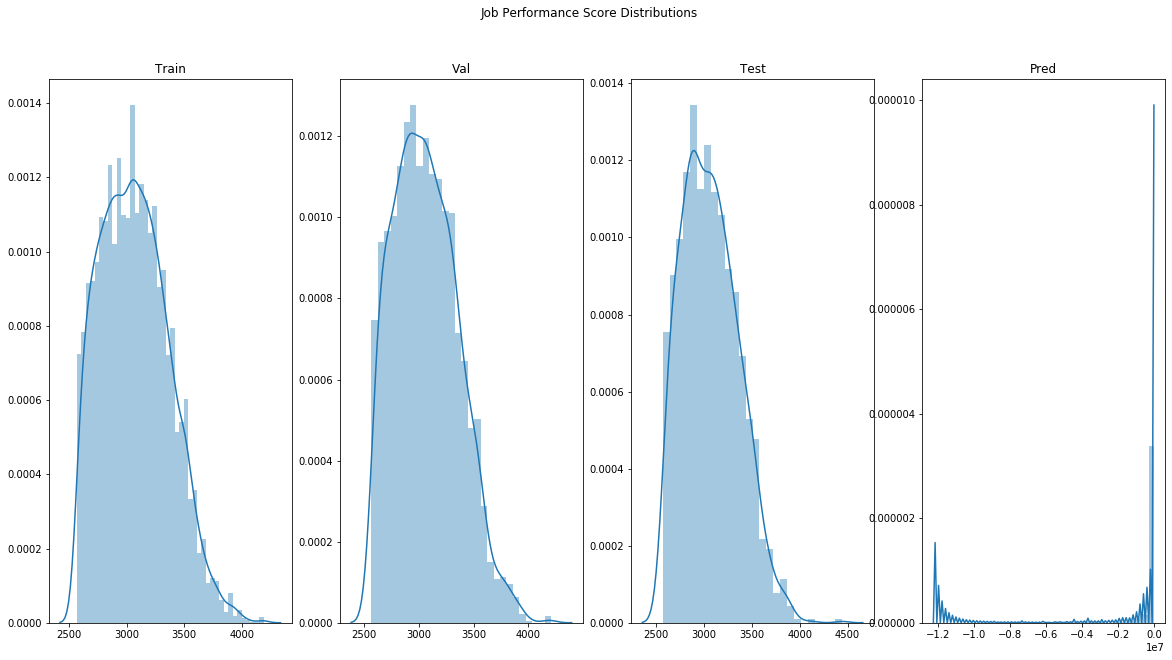

In [311]:
plot_label_results(y_train, y_val, y_test, y_pred)

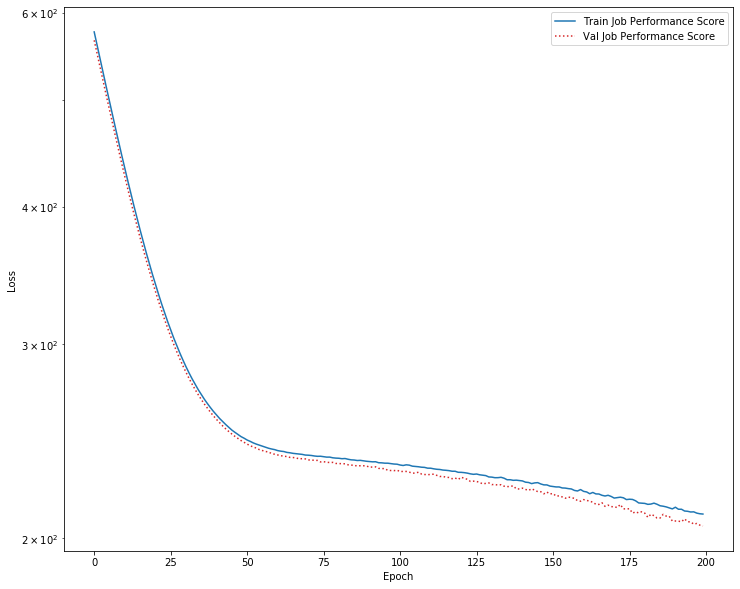

In [312]:
plot_loss(history, label="Job Performance Score", n=2)

## TPOT Pipeline

In [0]:
# from timeit import default_timer

# drive.mount(DRIVENAME)
# df = pd.read_csv(FILENAME, header='infer')
# df = (df.drop(index=get_outliers_and_extremes(df, numeric_attribute='job_performance').index, inplace=False, axis=0) # drop outliers
#         .drop(labels=detect_highly_correlated_variables(df), inplace=False, axis=1) # drop highly related correlated variables
#         .replace(to_replace=CONSIDERED_MISSING_VALUES, value=np.nan, inplace=False) # missing value encoding
#         .drop(labels=list(set([feature for feature in df.columns if (df[feature].isnull().sum(axis=0) / df.shape[0]) >= 0.6])-set(detect_highly_correlated_variables(df))),
#              inplace=False, 
#              axis=1))
# df = (df.drop(index=list(df[((df.isnull().sum(axis=1)/df.shape[1]) >= 0.40) == True].index), # drop rows that have more than 40% of values missing
#              inplace=False,
#              axis=0) # drop observations with greater than 40% of values missing
#        .drop(labels=REDUNDANT_FEATURES, inplace=False, axis=1)) # drop redundant features

# numeric_df, categorical_df = df_by_type_splitter(df)
# categorical_df = transform_all(categorical_df, BINARY_VARIABLE_MAPPING, ORDINAL_VARIABLE_MAPPING)

# df = (pd.concat([numeric_df, categorical_df], axis=1)
#         .drop(labels=list(numeric_df.loc[:, ((numeric_df.isnull().sum(axis=0) / numeric_df.shape[0]) >= 0.6)].columns), 
#               inplace=False, axis=1))

# # Imputation of Missing Features
# start_time = default_timer()
# df = impute_missing_for_dataframe(df, target="job_performance")
# df = round_selected_attributes_imputed(df[categorical_df.columns], df[[col for col in df.columns if col not in categorical_df.columns]])
# end_time = default_timer()>>> from sklearn.feature_selection import SelectKBest
# >>> from sklearn.feature_selection import chi2
# print("Impute time: {}".format(end_time - start_time))

# # Feature Selection
# start_time = default_timer()
# X_train, X_test, y_train, y_test = split_dataframe(df, target="job_performance", test_size=0.3, random_state=123)
# feature_indices, feature_names = select_n_features(X_train, y_train, n_features=round(0.33*len(df.columns)-1))
# end_time = default_timer()
# print("Feature Selection Time: {}".format(end_time - start_time))

# # Model Selection
# start_time = default_timer()
# TPOT_model_selection_and_HPO(df[feature_names], test_size=0.3)
# end_time = default_timer()
# print("Model Selection Time: {}".format(end_time - start_time))